In [22]:
# %matplotlib notebook # comment this line when working in VSCode
import aipy, uvtools
import numpy as np
import pylab as plt
import random
import math
import os.path

from hera_sim import foregrounds, noise, sigchain, rfi, simulate
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
def get_k_rand_nums(start, stop, k):
    return sorted([random.uniform(start, stop) for x in range(k)])

def plot_one_vis(vis, ylim):
    plt.figure()
    plt.subplot(211); uvtools.plot.waterfall(vis, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,ylim)
    plt.subplot(212); uvtools.plot.waterfall(vis, mode='phs'); plt.colorbar(); plt.ylim(0,ylim)
    plt.show()

MX, DRNG = 2.5, 3


# Generate a waterfall plot
Stored in `vis`

In [4]:
# ORIGINAL
lsts = np.linspace(1,2*np.pi,4000, endpoint=False) # local sidereal times; start range, stop range, number of snapshots
fqs = np.linspace(.1,.2,1024,endpoint=False) # frequencies in GHz
# times = lsts / (2*np.pi) * aipy.const.sidereal_day 
bl_len_ns = np.array([30.,0,0]) # ENU coordinates

### Generate point source foreground

In [5]:
# foregrounds.pntsrc_foreground?

/anaconda3/lib/python3.6/site-packages/uvtools/plot.py:40: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(data)


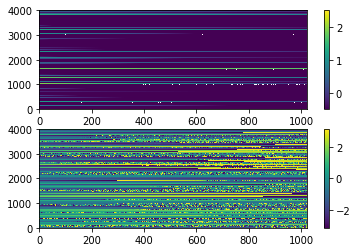

In [6]:
vis = foregrounds.pntsrc_foreground(lsts, fqs, bl_len_ns, nsrcs=200)

plot_one_vis(vis, 4000)

In [7]:
vis.shape

(4000, 1024)

### Generate diffuse source foreground

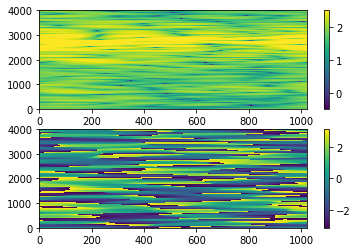

In [8]:
# bl_len_ns = np.array([30.])
Tsky_mdl = noise.HERA_Tsky_mdl['xx']
vis = vis + foregrounds.diffuse_foreground(lsts, fqs, bl_len_ns, Tsky_mdl) # add diffuse FG

MX, DRNG = 2.5, 3
plot_one_vis(vis, 4000)

### Generate and shuffle RFI

In [9]:
# rfi.rfi_stations?

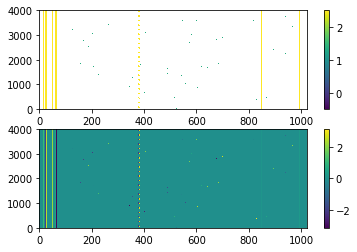

In [10]:
rfi1 = rfi.rfi_stations(fqs, lsts) # Default list of stations: rfi.HERA_RFI_STATIONS
rfi2 = rfi.rfi_impulse(fqs, lsts, chance=.02) # ORIGINAL: .02
rfi3 = rfi.rfi_scatter(fqs, lsts, chance=.001) # ORIGINAL: .001
rfi_all = rfi1 + rfi2 + rfi3

plot_one_vis(rfi_all, 4000)

In [11]:
# This function will be called on an individual waterfall plot
def add_random_rfi(plot):
    np.random.shuffle(rfi_all.T)
    return plot + rfi_all

### Generate noise
Should have variations!

In [12]:
# noise.sky_noise_jy?

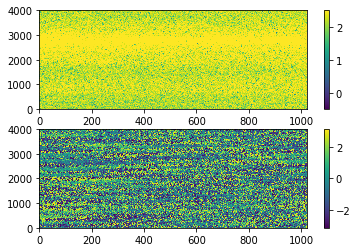

In [13]:
tsky = noise.resample_Tsky(fqs,lsts,Tsky_mdl=noise.HERA_Tsky_mdl['xx'])
t_rx = 150.
OMEGA_P = (0.72)*np.ones(1024) 
# .72 or smaller for omega_p; provided by Adrian, from literature

nos_jy = noise.sky_noise_jy(tsky + t_rx, fqs, lsts, OMEGA_P)
vis = vis + nos_jy
plot_one_vis(vis, 4000)

### Gain and Crosstalk

In [16]:
# sigchain??

In [21]:
# g = sigchain.gen_gains(fqs, [1,2,3])

# gainscale = np.average([np.median(np.abs(g[i])) for i in g])
# MX = MX + np.log10(gainscale)

# vis = sigchain.apply_gains(vis, g, (1,2))

# xtalk = sigchain.gen_cross_coupling_xtalk(fqs)
# vis = sigchain.apply_xtalk(vis, xtalk)
# vis = sigchain.apply_gains(vis, g, (1,2))

In [20]:
sigchain.gen_cross_coupling_xtalk??

# Generate visibility plot

In [50]:
def generate_vis():
    lsts = np.linspace(1,2*np.pi,4000, endpoint=False) # local sidereal times; start range, stop range, number of snapshots
    fqs = np.linspace(.1,.2,1024,endpoint=False) # frequencies in GHz
    bl_len_ns = np.array([30.,0,0]) # ENU coordinates
    
    vis = foregrounds.pntsrc_foreground(lsts, fqs, bl_len_ns, nsrcs=200)
    Tsky_mdl = noise.HERA_Tsky_mdl['xx']
    vis = vis + foregrounds.diffuse_foreground(lsts, fqs, bl_len_ns, Tsky_mdl) # add diffuse FG
    tsky = noise.resample_Tsky(fqs,lsts,Tsky_mdl=noise.HERA_Tsky_mdl['xx'])
    t_rx = 150.
    OMEGA_P = (0.72)*np.ones(1024)

    nos_jy = noise.sky_noise_jy(tsky + t_rx, fqs, lsts, OMEGA_P)
    vis = vis + nos_jy
    
    return vis

# Generate dataset

Layer one visibility plot with `m` different RFI shuffles, then split each version (including the original untainted plot) into `l` data points, for a total dataset size of `(m+1)*l`.

In [48]:
def generate_dataset(vis, l, m):
    ################################################
    # Split clean plot by lst and add to dataset
    # e.g. (4000, 1024) => l arrays of size (4000/l, 1024)
    dataset = np.array(np.split(vis, l))
    zeros = np.zeros(l, dtype=int)
    labels = zeros # add labels

    # --------------------------------------------#
    # COMMENT ABOVE LINES AND UNCOMMENT BELOW LINES
    # TO GENERATE AN RFI-ONLY DATASET
#     dataset = np.split(add_random_rfi(vis), l)
#     labels = np.ones(l, dtype=int)
    ################################################
    
    # Add m different RFI shuffles, then split and add to dataset
    for j in range(m):
        temp = add_random_rfi(vis)
        dataset = np.concatenate((dataset, np.split(temp, l)))
        labels = np.concatenate((labels, np.ones(l, dtype=int)))
    
    #################################################################
    # COMMENT OUT BELOW LINES IF NOT SEPARATING DATA INTO COMPONENTS
    
    # Separate and concatenate real/imag components of the dataset
    dim1 = dataset.shape[0] # e.g. 1200
    dim2 = dataset.shape[1] # e.g. 20
    dim3 = dataset.shape[2] # e.g. 1024 ==> 2048

    temp = np.zeros((dim1, dim2, dim3*2))
    for i in range(dim1):
        for j in range(dim2):
            cp = dataset[i][j] # complex value
            temp[i][j][0:dim3] = cp.real
            temp[i][j][dim3:dim3*2] = cp.imag

    dataset = temp
    #################################################################
    
    return dataset, labels

def export_dataset(dataset, labels):
    i = 1
    while(os.path.isfile(f'dataset{i}.npy')):
        i = i+1
    np.save(f'dataset{i}.npy', dataset)
    np.save(f'labels{i}.npy', labels)
    if len(dataset) == len(labels):
        print(f'Dataset of size {len(dataset)} exported as `dataset{i}.npy`.')
    

### Generate clean dataset

In [128]:
d1, l1 = generate_dataset(generate_vis(), 200, 0)
d2, l2 = generate_dataset(generate_vis(), 200, 0)
d3, l3 = generate_dataset(generate_vis(), 200, 0)

d = np.concatenate((d1,d2,d3))
l = np.concatenate((l1,l2,l3))

export_dataset(d, l)

Dataset of size 600 exported as `dataset1.npy`.


### Generate RFI or mixed dataset

In [51]:
D, L = generate_dataset(generate_vis(), 200, 2)
export_dataset(D,L)

KeyboardInterrupt: 

### Generate normalized & standardized dataset

In [54]:
D1, L1 = generate_dataset(generate_vis(), 200, 1)
D2, L2 = generate_dataset(generate_vis(), 200, 1)
D3, L3 = generate_dataset(generate_vis(), 200, 1)

D = np.concatenate((D1,D2,D3))
L = np.concatenate((L1,L2,L3))

for plot in D:
    scaler = StandardScaler()
    plot = scaler.fit_transform(plot)
    
export_dataset(D,L)

'''
def preprocess(D):
    # Normalize to [-1, 1]
    # https://stackoverflow.com/questions/53870113/using-standardscaler-on-3d-data
    dim1, dim2, dim3 = D.shape
#     scaler = MinMaxScaler(feature_range=(-1,1))
    D = np.reshape(D, newshape=(-1, dim3)) # each feature is one column
    D = scaler.fit_transform(D)

    # Standardize (mean => 0, std => 1)
    scaler = StandardScaler()
    D = scaler2.fit_transform(D)

    D = np.reshape(D, newshape=(dim1, dim2, dim3)) # return to original shape
    return D
'''

# D = preprocess(D)
# export_dataset(D,L)

Dataset of size 1200 exported as `dataset3.npy`.


'\ndef preprocess(D):\n    # Normalize to [-1, 1]\n    # https://stackoverflow.com/questions/53870113/using-standardscaler-on-3d-data\n    dim1, dim2, dim3 = D.shape\n#     scaler = MinMaxScaler(feature_range=(-1,1))\n    D = np.reshape(D, newshape=(-1, dim3)) # each feature is one column\n    D = scaler.fit_transform(D)\n\n    # Standardize (mean => 0, std => 1)\n    scaler = StandardScaler()\n    D = scaler2.fit_transform(D)\n\n    D = np.reshape(D, newshape=(dim1, dim2, dim3)) # return to original shape\n    return D\n'

In [46]:
a1 = np.array([1,2,3,4])
a2 = np.array([600,650,700,750])
a = [a1, a2]
scaler = StandardScaler()
a = scaler.fit_transform(a)
a


array([[-1., -1., -1., -1.],
       [ 1.,  1.,  1.,  1.]])

In [45]:
a1 = np.array([1,2,3,4])
a2 = np.array([600,650,700,750])
a1 = a1-np.mean(a1)
a2 = a2-np.mean(a2)

a = [a1, a2]
scaler = MinMaxScaler(feature_range=(-1,1))
a = scaler.fit_transform(a)

a

array([[ 1.,  1., -1., -1.],
       [-1., -1.,  1.,  1.]])